# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Build a Lane Finding Pipeline



### Helper functions

In [2]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Common definition of ROI vertices, used both for color and edge based line detections
def get_ROI_vertices(image):
    return np.array([[(50, image.shape[0]), (460, image.shape[0] - 250), (image.shape[1] - 460, image.shape[0] - 250),
                      (image.shape[1] - 50, image.shape[0])]], dtype=np.int32)

### Find lines by edge extraction

Use canny edge detector and hough tranform to detect raw line segments 

In [3]:
def find_lines_by_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges, get_ROI_vertices(edges))

    # Define the Hough transform parameters
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20   # minimum number of pixels making up a line
    max_line_gap = 7  # maximum gap in pixels between connectible line segments

    lines = cv2.HoughLinesP(masked_edges, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    return lines

### Find lines by color

Color thresholding to detect white and yellow foreground objects, then do some morphological operations to reduce noise and get a skeletonized representation of the forground objects. The hough transform is then used to extract line segments.

In [4]:
def color_threshold_yellow(hsv_image):
    hsv_lower_th = np.array([20, 70, 120])
    hsv_upper_th = np.array([25, 255, 245])
    mask = cv2.inRange(hsv_image, hsv_lower_th, hsv_upper_th)
    return mask


def color_threshold_white(hsv_image):
    hsv_lower_th = np.array([0, 0, 240])
    hsv_upper_th = np.array([255, 255, 255])
    mask = cv2.inRange(hsv_image, hsv_lower_th, hsv_upper_th)
    return mask


# Use morphological operations to remove some noise from a binary image
def remove_noise(binary_image):

    # Fix small holes in foreground object with morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    output_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    # I also evaluated different kernels for removing small foreground objects using morphological
    # opening, but with bad result on the lane lines.

    return output_image


# Use morphological operations to reduce foreground objects until only the skeleton remains
def skeletonize(binary_image):
    size = np.size(binary_image)
    skel_image = np.zeros(binary_image.shape, np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    while True:
        eroded = cv2.erode(binary_image, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(binary_image, temp)
        skel_image = cv2.bitwise_or(skel_image, temp)
        binary_image = eroded.copy()

        # Repeat until the binary image operations above have no more effect
        zeros = size - cv2.countNonZero(binary_image)
        if zeros == size:
            break

    return skel_image


def find_lines_by_colors(rgb_image):
    # Convert the RGB image to HSV to make color thresholding a little bit more robust, or at least easier.
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    yellow_mask = color_threshold_yellow(hsv_image)
    white_mask = color_threshold_white(hsv_image)

    # Combine the yellow and white binary images
    lines_mask = cv2.bitwise_or(yellow_mask, white_mask)

    # Clear everything but region of interest
    roi_lines_mask = region_of_interest(lines_mask, get_ROI_vertices(lines_mask))

    # Remove some holes in detected lines
    filered_mask = remove_noise(roi_lines_mask)

    # Reduce detected lines into just a skeleton
    skeleton_image = skeletonize(filered_mask)
    # Define the Hough transform parameters
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectible line segments

    lines = cv2.HoughLinesP(skeleton_image, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    return lines

### Group togheter similar lines
Look at raw line segments slope and y-axis interception to figure out which segments belong togheter.


In [5]:
def calc_slopes(lines):
    slopes = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slopes.append((y2 - y1) / (x2 - x1))

    return np.array(slopes)


def calc_intercepts(lines, slopes):
    intercepts = []
    for line, slope in zip(lines, slopes):
        for x1, y1, x2, y2 in line:
            intercepts.append(y1 - slope * x1)

    return np.array(intercepts)


def calc_lengths(lines):
    lengths = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            lengths.append(math.sqrt(math.pow(y1 - y2, 2) + math.pow(x1 - x2, 2)))

    return np.array(lengths)


def extract_coords(lines):
    x1_coords = []
    x2_coords = []
    y1_coords = []
    y2_coords = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            x1_coords.append(x1)
            y1_coords.append(y1)
            x2_coords.append(x2)
            y2_coords.append(y2)

    return np.array(x1_coords), np.array(y1_coords), np.array(x2_coords), np.array(y2_coords)

class LinesData:
    def __init__(self, lines, slopes=None, intercepts=None):
        self.lines = lines
        if slopes is None:
            self.slopes = calc_slopes(self.lines)
        else:
            self.slopes = slopes
        if intercepts is None:
            self.intercepts = calc_intercepts(self.lines, self.slopes)
        else:
            self.intercepts = intercepts

    def reorder(self, new_indices):
        self.lines = self.lines[new_indices]
        self.slopes = self.slopes[new_indices]
        self.intercepts = self.intercepts[new_indices]


# Group together lines that have similar slope and y-axis intercept
def find_similar_lines(lines_data):
    # Find the two slope ranges that seems to be most frequent. The assumption will be that they belong to left and
    # right lane line. The lengths of the lines are used as weights to not benefit noisy line detections.
    hist, bin_edges = np.histogram(lines_data.slopes, bins=50, range=(-5.0, 5.0),
                                   weights=calc_lengths(lines_data.lines))
    sorted_hist_indices = np.argsort(hist)[::-1]

    # For now, only find the two most similar groups of lines
    num_lines_to_find = 2
    similar_lines = []
    for idx in range(num_lines_to_find):
        if hist[sorted_hist_indices[idx]] == 0:
            # No more lines to find
            break
        slope_range = (bin_edges[sorted_hist_indices[idx]], bin_edges[sorted_hist_indices[idx] + 1])

        # Gather all lines with expected slopes
        indices = np.where(np.logical_and(lines_data.slopes >= slope_range[0],
                                          lines_data.slopes < slope_range[1]))[0]
        # Remove lines that not have the same intercept (with some tolerance)
        max_intercept_deviation = 70.0
        median_intercept = np.median(lines_data.intercepts[indices])
        intercept_range = [median_intercept - max_intercept_deviation,
                           median_intercept + max_intercept_deviation]

        indices = indices[np.where(np.logical_and(lines_data.intercepts[indices] >= intercept_range[0],
                                                  lines_data.intercepts[indices] <= intercept_range[1]))]

        # Quick fix for a bug where there sometimes are no lines near median intercept value.
        # It would be better to use histogram also for the intercept values.
        if len(indices) > 0:
            similar_lines.append(LinesData(lines=lines_data.lines[indices],
                                           slopes=lines_data.slopes[indices],
                                           intercepts=lines_data.intercepts[indices]))
    return similar_lines

### Find average lines from groups of line segments

In [6]:
def calc_average_line(lines_data):
    # Start with line closest to camera (largest y-coordinate), assuming they are the most accurate,
    # and that they at least should be included in average.

    # Sort lines by bottom y-coordinate
    _, y1_coords, _, y2_coords = extract_coords(lines_data.lines)
    bottom_y_coords = np.where(y1_coords >= y2_coords, y1_coords, y2_coords)
    sorted_indices = np.argsort(bottom_y_coords)[::-1]
    lines_data.reorder(sorted_indices)

    max_slope_deviation = 0.1  # Allowed deviation from current average
    max_intercept_deviation = 20  # Allowed deviation from current average
    average_slope = lines_data.slopes[0]
    average_intercept = lines_data.intercepts[0]
    average_count = 0  # Don't count the above initialization
    bottom_y = 0
    top_y = np.inf
    right_x = 0
    left_x = np.inf

    for line, slope, intercept in zip(lines_data.lines, lines_data.slopes, lines_data.intercepts):
        if (slope >= (average_slope - max_slope_deviation) and
            slope <= (average_slope + max_slope_deviation) and
            intercept >= (average_intercept - max_intercept_deviation) and
            intercept <= (average_intercept + max_intercept_deviation)):

            average_slope = ((average_slope * average_count) + slope) / (average_count + 1)
            average_intercept = ((average_intercept * average_count) + intercept) / (average_count + 1)
            average_count += 1

            # Find extreme coordinates of lines that are within max allowed deviation
            for x1, y1, x2, y2 in line:
                bottom_y = max(bottom_y, y1, y2)
                top_y = min(top_y, y1, y2)
                right_x = max(right_x, x1, x2)
                left_x = min(left_x, x1, x2)

    # Use average slope and intercept to calculate a line from bottom_y to top_y
    if average_slope < 0.0001 and average_slope > -0.0001:
        # Horizontal line, this is somewhat unexpected but lets output the line anyway
        average_x1 = left_x
        average_x2 = right_x
    else:
        average_x1 = (bottom_y - average_intercept) / average_slope
        average_x2 = (top_y - average_intercept) / average_slope

    average_y1 = bottom_y
    average_y2 = top_y

    return np.round([[[average_x1, average_y1, average_x2, average_y2]]]).astype(int)


### Main processing loop

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:23<00:00, 28.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:15<00:00, 15.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



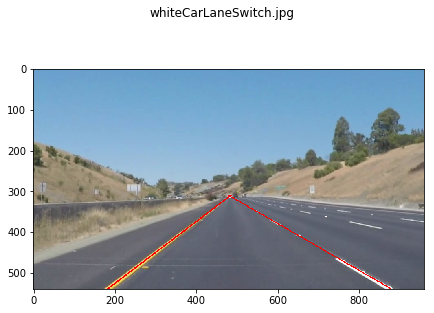

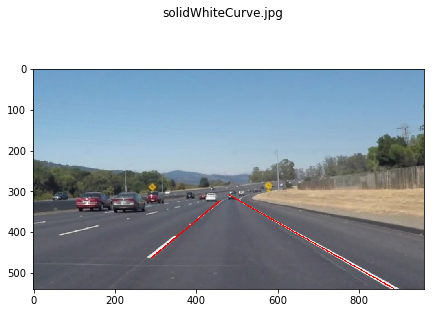

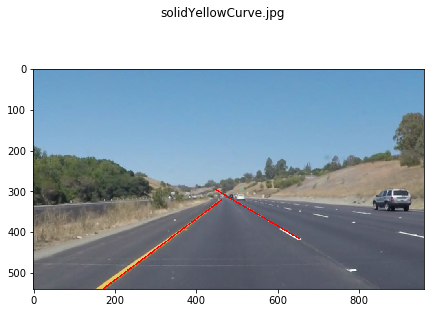

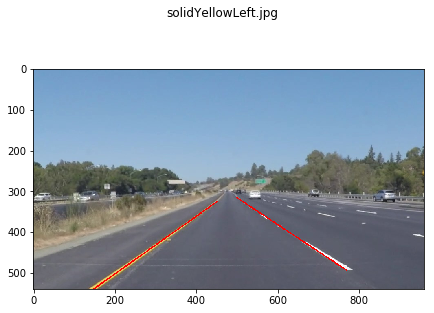

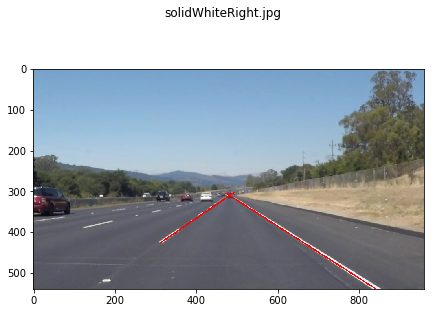

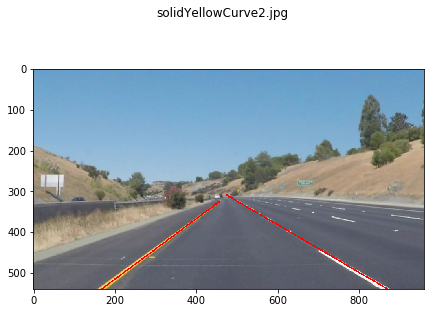

In [7]:
def calc_lane_lines(lines):
    allLines = LinesData(lines)
    similar_lines = find_similar_lines(allLines)

    lane_lines = []
    for line in similar_lines:
        lane_lines.append(calc_average_line(line))

    return lane_lines


def find_lines(rgb_image):
    all_lines = None
    output_image = np.copy(rgb_image)

    edge_lines = find_lines_by_edges(rgb_image)
    if edge_lines is not None:
        all_lines = edge_lines

    color_lines = find_lines_by_colors(rgb_image)
    if color_lines is not None:
        if all_lines is not None:
            all_lines = np.concatenate((all_lines, color_lines), axis=0)
        else:
            all_lines = color_lines

    lane_lines = calc_lane_lines(all_lines)
    for line in lane_lines:
        draw_lines(output_image, line, color=[255, 0, 0])

    return output_image


def process_image(image):
    result = find_lines(image)
    return result


def process_image_files():
    import os
    for file in os.listdir("test_images/"):
        rgb_image = mpimg.imread('test_images/' + file)
        result_image = process_image(rgb_image)
        fig = plt.figure(figsize=(7, 5))
        fig.suptitle(f"{file}", fontsize=12)
        plt.imshow(result_image)
        
def process_video_files():
    # Import everything needed to edit/save/watch video clips
    from moviepy.editor import VideoFileClip

    output_file_name = 'test_videos_output/solidWhiteRight.mp4'
    clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
    clip = clip1.fl_image(process_image)
    clip.write_videofile(output_file_name, audio=False)

    output_file_name = 'test_videos_output/solidYellowLeft.mp4'
    clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
    clip = clip1.fl_image(process_image)
    clip.write_videofile(output_file_name, audio=False)

    output_file_name = 'test_videos_output/challenge.mp4'
    clip1 = VideoFileClip("test_videos/challenge.mp4")
    clip = clip1.fl_image(process_image)
    clip.write_videofile(output_file_name, audio=False)


process_image_files()
process_video_files()

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/solidWhiteRight.mp4'))

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/solidYellowLeft.mp4'))

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_videos_output/challenge.mp4'))